<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report 

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

In [6]:
def moveup(img):
    while True:
        if np.all(img[0] >= 240):
            img = img[1:]
        else:
            break
    return img

def movedown(img):
    while True:
        if np.all(img[-1] >= 240):
            img = img[:-1]
        else:
            break
    return img

def moveleft(img):
    while True:
        if np.all(img[:, 0] >= 240):
            img = img[:, 1:]
        else:
            break
    return img

def moveright(img):
    while True:
        if np.all(img[:, -1] >= 240):
            img = img[:, :-1]
        else:
            break
    return img

def rescale(img):
    img = moveup(img)
    img = movedown(img)
    img = moveleft(img)
    img = moveright(img)
    return img

# STEP 2 : Preparing & inspection

Prepare for inspections

In [7]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [8]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\9\nine2.png,9
1,./Thainumber\2\two1.png,2
2,./Thainumber\9\IMG_0950.png,9
3,./Thainumber\5\5-36.png,5
4,./Thainumber\3\3-7.png,3
...,...,...
695,./Thainumber\2\2-30.png,2
696,./Thainumber\7\7-12.png,7
697,./Thainumber\2\2-29.png,2
698,./Thainumber\8\8-4.png,8


In [9]:
data.shape

(700, 2)

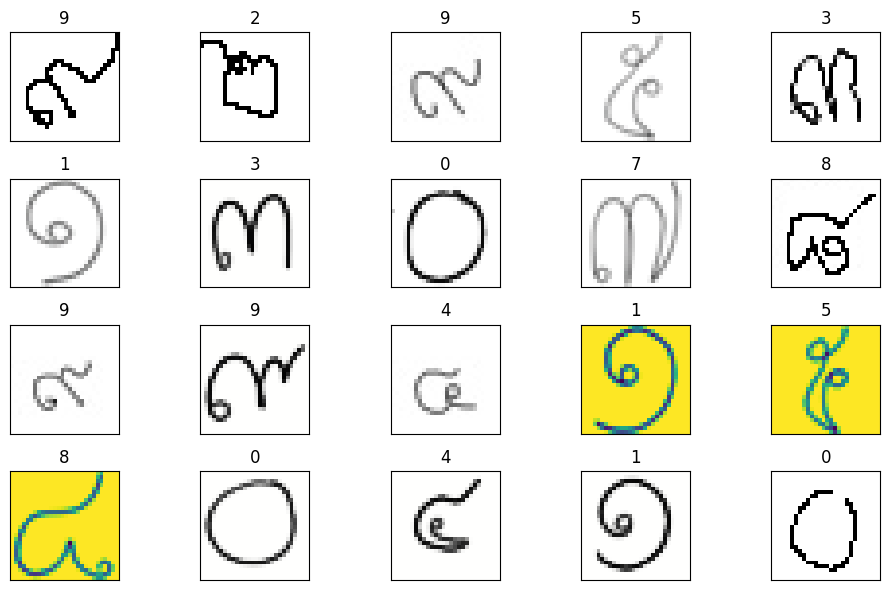

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

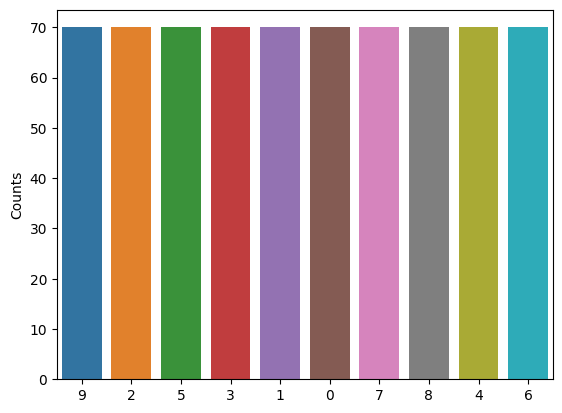

In [11]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [12]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = rescale(img)
    img = cv2.resize(img, (28, 28))
    img = img.flatten()
 
    read_x.append(img)

x = np.asarray(read_x)

In [13]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [14]:
df = pd.concat([x,y] , axis=1)
#df.to_csv('image_df.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,9
1,0,0,0,0,0,0,0,0,146,255,...,255,219,36,0,0,0,0,109,255,2
2,255,255,255,255,255,255,255,255,255,255,...,251,243,244,254,255,255,255,255,255,9
3,255,255,255,255,255,255,255,255,255,255,...,236,215,193,196,204,234,255,255,255,5
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,3


In [15]:
# Binarize the output

#y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
#print(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.20, random_state = 42, stratify = y )

# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [17]:
from pycaret.classification import *

s = setup( df, target = 'Label', session_id = 123, train_size = 0.7  )

In [18]:
best = s.compare_models( sort = 'Accuracy', fold = 5, n_select = 3 )
pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:14:39
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9693,0.9986,0.9693,0.9719,0.9692,0.9659,0.9662,3.138
lr,Logistic Regression,0.9652,0.9978,0.9652,0.9685,0.9655,0.9614,0.9617,4.578
rf,Random Forest Classifier,0.9570,0.9974,0.9570,0.9621,0.9568,0.9523,0.9529,3.188
lightgbm,Light Gradient Boosting Machine,0.9284,0.9964,0.9284,0.9384,0.9281,0.9205,0.9217,4.402
svm,SVM - Linear Kernel,0.9121,0.0000,0.9121,0.9316,0.9106,0.9023,0.9049,2.976
knn,K Neighbors Classifier,0.8771,0.9891,0.8771,0.8969,0.8752,0.8635,0.8657,3.708
gbc,Gradient Boosting Classifier,0.8568,0.9879,0.8568,0.8735,0.8576,0.8408,0.8425,14.560
lda,Linear Discriminant Analysis,0.8222,0.9755,0.8222,0.8387,0.8218,0.8024,0.8042,2.884
dt,Decision Tree Classifier,0.7894,0.8830,0.7894,0.8035,0.7885,0.7660,0.7677,2.822
nb,Naive Bayes,0.7606,0.8935,0.7606,0.8193,0.7641,0.7340,0.7409,3.074


In [19]:
display(best)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        

In [20]:
tuned_model = tune_model( best[0], optimize = 'Accuracy', n_iter = 30, fold = 5 )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:20:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9490,0.9959,0.9490,0.9519,0.9488,0.9433,0.9436
1,0.9286,0.9957,0.9286,0.9409,0.9272,0.9206,0.9222
2,0.9388,0.9983,0.9388,0.9443,0.9383,0.9320,0.9326
3,0.9796,0.9971,0.9796,0.9805,0.9796,0.9773,0.9774
4,0.9485,0.9968,0.9485,0.9622,0.9492,0.9427,0.9443
Mean,0.9489,0.9968,0.9489,0.9560,0.9486,0.9432,0.9440
Std,0.0171,0.0009,0.0171,0.0143,0.0175,0.0190,0.0186


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9490,0.9959,0.9490,0.9519,0.9488,0.9433,0.9436
1,0.9286,0.9957,0.9286,0.9409,0.9272,0.9206,0.9222
2,0.9388,0.9983,0.9388,0.9443,0.9383,0.9320,0.9326
3,0.9796,0.9971,0.9796,0.9805,0.9796,0.9773,0.9774
4,0.9485,0.9968,0.9485,0.9622,0.9492,0.9427,0.9443
Mean,0.9489,0.9968,0.9489,0.9560,0.9486,0.9432,0.9440
Std,0.0171,0.0009,0.0171,0.0143,0.0175,0.0190,0.0186


Fitting 5 folds for each of 30 candidates, totalling 150 fits


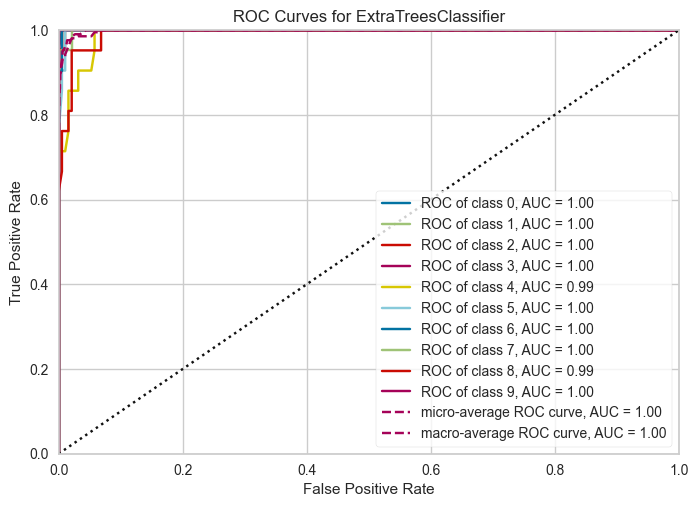

In [21]:
plot_model(tuned_model, plot = 'auc')

<h4>Pipeline</h4>

In [22]:
steps = [
    ('scalar', MinMaxScaler()),
    ('ExtraTreesClassifier',ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False))
]

pipeline = Pipeline(steps)

In [23]:
pr = pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))

Training score: 1.0


# STEP 4 : Test

In [24]:
y_pred = pr.predict(X_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.93      1.00      0.97        14
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        14
           4       0.82      1.00      0.90        14
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.93      0.96        14
           8       1.00      0.79      0.88        14
           9       0.93      1.00      0.97        14

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



<h4>Evaluations</h4>